(Precision_Top_K_Metrics)=
# Precision top-k metrics

This section addresses the relevance of a credit card FDS from a more operational perspective, by explicitly considering their benefits for fraud investigators. Let us first recall that the purpose of an FDS is to provide investigators with *alerts*, that is, a set of transactions that are assumed to be the most suspicious (see Section {ref}`Fraud_Detection_System`). These transactions are manually checked, by contacting the cardholder. The process of contacting cardholders is time-consuming, and the number of fraud investigators is limited. The number of alerts that may be checked during a given period is therefore necessarily limited.

*Precision top-$k$* metrics aim at quantifying the performance of an FDS in this setting {cite}`dal2017credit,dal2015adaptive,fan2011detection`. Precisions are computed daily, reflecting the precisions obtained for a working day of fraud investigators. The $k$ parameter quantifies the maximum number of alerts that can be checked by investigators in a day. 

Formally, for a day $d$, let us denote by $\mathcal{T}_d$ the set of transactions. Only a minority of transactions $\mathcal{T}_d^{Fraud} \subset \mathcal{T}_d$ is fraudulent, while the majority $\mathcal{T}_d^{Genuine} \subset \mathcal{T}_d$ are genuine. Let us further denote by $\mathcal{A}_d$ the set of alerts. The set of alerts contains both true positives ($\mathcal{A}_d^{Fraud}$), and false positives ($\mathcal{A}_d^{Genuine}$). Fig. 1 provides a schematic illustration.  

![](images/hits_per_day_with_caption.png)

Denoting by $k$ the number of alerts that investigators can process during a day, and by $|.|$ the cardinality of a set, we have $|\mathcal{A}_d|=k$, with $k << |\mathcal{T}_d|$. 

In this setting, the performance of a classifier is to maximize the precision in the subset $\mathcal{A}_d$, that is, to maximize

$$P@k(d)=\frac{|\mathcal{A}_d^{Fraud}|}{|\mathcal{A}_d|}=\frac{|\mathcal{A}_d^{Fraud}|}{k}$$

This quantity is referred to as the *Precision top-$k$ for day $d$* {cite}`dal2017credit,dal2015adaptive`, or $P@k(d)$. An alternative to this measure is the *Card Precision top-$k$*, which measures the *Precision top-$k$* in terms of cards rather than authorized transactions. Multiple transactions in $|A_d|$ from the same card should be counted as a single alert since investigators check all the recent transactions when contacting cardholders. The *Card Precision top-$k$ for day $d$* is referred to as $CP@k(d)$. 

We detail both these metrics in the following, together with their implementations. 


In [1]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed
        

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37136  100 37136    0     0   135k      0 --:--:-- --:--:-- --:--:--  135k


## Precision top-$k$

Let us reuse the [baseline fraud detection setup](Baseline_FDS), using one week of data for training, and one week of data for testing the detection performances. A decision tree of depth two is used as the prediction model.


In [2]:
# Load data from the 2018-07-25 to the 2018-08-14

DIR_INPUT='./simulated-data-transformed/data/' 

BEGIN_DATE = "2018-07-25"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=delta_delay=delta_test=7

(train_df,test_df)=get_train_test_set(transactions_df,start_date_training,
                                      delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature)    

Load  files
CPU times: user 243 ms, sys: 146 ms, total: 389 ms
Wall time: 406 ms
201295 transactions loaded, containing 1792 fraudulent transactions


The predictions for the test week are returned in the `predictions_test` entry of the `model_and_predictions_dictionary` dictionary. `predictions_test` is a vector that contains the fraud probabilities for each of the transactions in the `test_df` DataFrame. We can check that the number of predictions equals the number of transactions:

In [3]:
assert len(model_and_predictions_dictionary['predictions_test'])==len(test_df)

Let us add these predictions as a new column in the DataFrame of test transactions, and display the five first rows.

In [4]:
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
predictions_df[['TRANSACTION_ID','TX_DATETIME','CUSTOMER_ID','TERMINAL_ID','TX_AMOUNT','TX_TIME_DAYS','TX_FRAUD','predictions']].head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_DAYS,TX_FRAUD,predictions
134215,1236698,2018-08-08 00:01:14,2765,2747,-0.266899,129,0,0.003536
134216,1236699,2018-08-08 00:02:33,714,2073,1.295440,129,0,0.003536
134218,1236701,2018-08-08 00:08:40,4982,1258,-0.650902,129,0,0.003536
134219,1236702,2018-08-08 00:08:41,704,8501,0.290249,129,0,0.003536
134220,1236703,2018-08-08 00:10:34,3085,4208,0.039070,129,0,0.003536


The $P@k(d)$ can be computed for a day $d$ by ranking all fraud probabilities by decreasing order, and computing the precision for the top $k$ ranked transactions. Let us for example compute the precision obtained on the top 100 transactions, for the first day of transactions in the test set (day 129).

In [5]:
def precision_top_k_day(df_day, top_k=100):
    
    # Order transactions by decreasing probabilities of frauds
    df_day = df_day.sort_values(by="predictions", ascending=False).reset_index(drop=False)
        
    # Get the top k most suspicious transactions
    df_day_top_k=df_day.head(top_k)
    list_detected_fraudulent_transactions=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].TRANSACTION_ID)
    
    # Compute precision top k
    precision_top_k = len(list_detected_fraudulent_transactions) / top_k
    
    return list_detected_fraudulent_transactions, precision_top_k


day=129

df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
df_day = df_day[['TRANSACTION_ID','CUSTOMER_ID', 'TX_FRAUD', 'predictions']]

_, precision_top_k= precision_top_k_day(df_day=df_day, top_k=100)
precision_top_k


0.26

We get a precision of 0.26, that is, 26 out of the one hundred most highly suspicious transactions were indeed fraudulent transactions. 

It should be noted that the highest value that is achievable for the $P@k(d)$ may be lower than one. This is the case when $k$ is higher than the number of fraudulent transactions for a given day. In the example above, the number of fraudulent transactions at day 129 is 55.

In [8]:
df_day.TX_FRAUD.sum()

55

As a result, the maximum $P@100(129)$ which can be achieved is 55/100=0.55.

When a test set spans multiple days, let $P@k$ be the mean of $P@k(d)$ for a set of days $d \in \mathcal{D}$ {cite}`dal2017credit,dal2015adaptive`, that is:

$$
P@k = \frac{1}{|\mathcal{D}|}\sum_{d \in \mathcal{D}} P_k(d)
$$

Let us implement this score with a function `precision_top_k`, which takes as input a `predictions_df` DataFrame, and a `top_k` threshold. The function loops over all days of the DataFrame, and computes for each day the number of fraudulent transactions and the precision top-$k$. It returns these values for all days as lists, together with the resulting mean of the precisions top-$k$.  

In [7]:
def precision_top_k(predictions_df, top_k=100):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    precision_top_k_per_day_list = []
    nb_fraudulent_transactions_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['TRANSACTION_ID', 'CUSTOMER_ID', 'TX_FRAUD', 'predictions']]
        
        nb_fraudulent_transactions_per_day.append(len(df_day[df_day.TX_FRAUD==1]))
        
        _, _precision_top_k = precision_top_k_day(df_day, top_k=top_k)
        
        precision_top_k_per_day_list.append(_precision_top_k)
        
    # Compute the mean
    mean_precision_top_k = np.round(np.array(precision_top_k_per_day_list).mean(),3)
    
    # Returns number of fraudulent transactions per day,
    # precision top k per day, and resulting mean
    return nb_fraudulent_transactions_per_day,precision_top_k_per_day_list,mean_precision_top_k


Applying this function to the `prediction_df`, with $k=100$, we get:

In [8]:
nb_fraudulent_transactions_per_day_remaining,\
precision_top_k_per_day_list,\
mean_precision_top_k = precision_top_k(predictions_df=predictions_df, top_k=100)

print("Number of remaining fraudulent transactions: "+str(nb_fraudulent_transactions_per_day_remaining))
print("Precision top-k: "+str(precision_top_k_per_day_list))
print("Average Precision top-k: "+str(mean_precision_top_k))

Number of remaining fraudulent transactions: [55, 60, 56, 56, 59, 58, 41]
Precision top-k: [0.26, 0.35, 0.26, 0.33, 0.3, 0.35, 0.19]
Average Precision top-k: 0.291


For better visualization, let us plot these data. We reuse the plotting function introduced in {ref}`Baseline_FDS_Training_Test_Sets` (imported from the [shared functions](shared_functions) notebook). First, we use the `get_tx_stats` function to compute the number of transactions per day, fraudulent transactions per day, and frauded cards per day. We then add the *remaining* fraudulent transactions per day, and precision top-$k$ per day to the DataFrame, for the seven days of the test period.

In [9]:
# Compute the number of transactions per day, 
#fraudulent transactions per day and fraudulent cards per day
tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")

# Add the remaining number of fraudulent transactions for the last 7 days (test period)
tx_stats.loc[14:20,'nb_fraudulent_transactions_per_day_remaining']=list(nb_fraudulent_transactions_per_day_remaining)
# Add precision top k for the last 7 days (test period) 
tx_stats.loc[14:20,'precision_top_k_per_day']=precision_top_k_per_day_list


Note that the *remaining* number of fraudulent transactions is the number of fraudulent transactions originally present in the test period, minus those transactions that belong to cards known to be frauded in the training set (see `get_train_test_set` function). We recall that these transactions should be removed when assessing the performance of the fraud detector on the test set, since the cards they belong to were known to be frauded when training the fraud detector. 

In [10]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

cmap = plt.get_cmap('jet')
colors={'precision_top_k_per_day':cmap(0), 
        'nb_fraudulent_transactions_per_day':cmap(200),
        'nb_fraudulent_transactions_per_day_remaining':cmap(250),
       }

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Number of fraudulent transactions per day \n and number of detected fraudulent transactions',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test,
                      ylim=150
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day - Original')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day_remaining'], 'b', color=colors['nb_fraudulent_transactions_per_day_remaining'], label = '# fraudulent txs per day - Remaining')
ax.plot(tx_stats['tx_date'], tx_stats['precision_top_k_per_day']*100, 'b', color=colors['precision_top_k_per_day'], label = '# detected fraudulent txs per day')
ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)
    

The resulting plot gives us 

* the number of fraudulent transactions originally present in the transaction dataset, for the training, delay, and test period
* the number of remaining transactions for the test period (original, minus those belonging to cards known to be fraudulent in the training period)
* the number of detected fraudulent transactions for the test period (precision top-$k$ times $k$). 

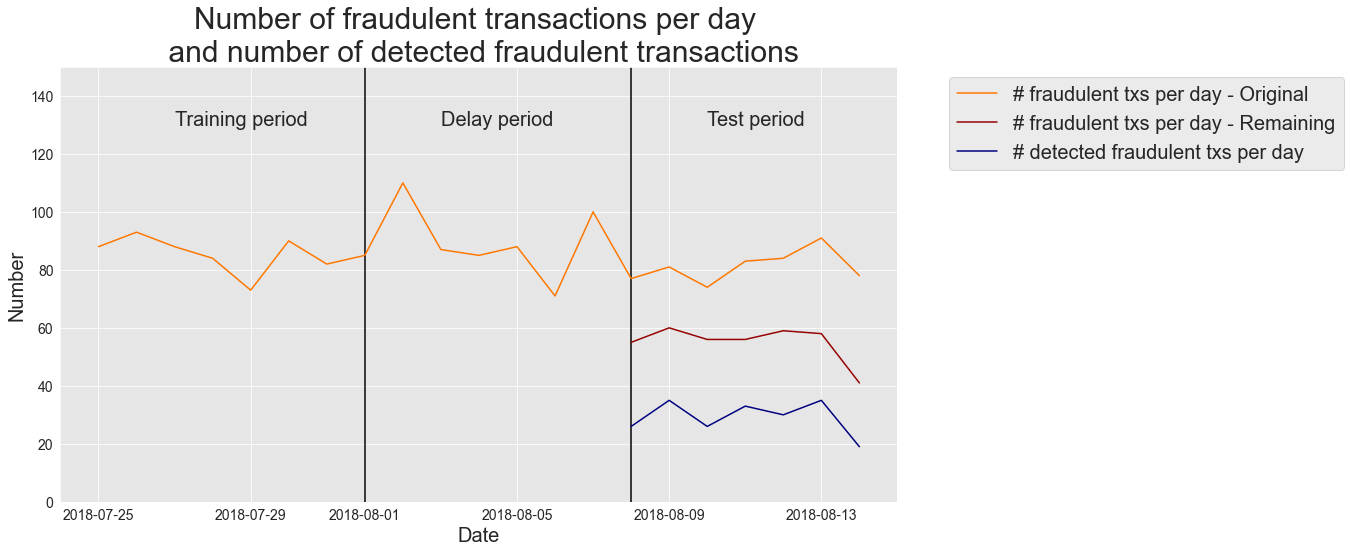

In [11]:
fraud_and_transactions_stats_fig

The graph shows a well-detailed summary of the performance of the fraud detector from an operational point of view. In the test period, the number of fraudulent transactions varied between 74 and 91. Once known frauded cards from the training period were removed, the remaining fraudulent transactions varied between 41 and 60. Out of these remaining fraudulent transactions, the fraud detector correctly detected between 19 and 35 transactions, with an average number of 29 fraudulent transactions detected per day (average precision top-$k$=0.29), that is, about 50% of the actual fraudulent transactions were detected.  

(Card_Precision_Top_K)=
## Card Precision top-$k$

As pointed out in the introduction, multiple fraudulent transactions from the same card should count as a single correct detection since investigators check all the recent transactions when contacting cardholders. The resulting metric is the *Card Precision Top-$k$*, or $CP@k$, and quantifies the number of correctly detected frauded cards out of the $k$ cards which have the highest risks of frauds.

$CP@k$ can be computed by slightly amending the implementation of the Precision top-$k$ given above. More specifically, instead of simply sorting transactions by decreasing order of their fraud probabilities, we first group transactions by customer ID. For each customer ID, we then take the maximum value of the fraud probability and the fraud label. This can be computed in a single line of code with the Panda `group_by` and `max` operators. The card precision top-$k$ is finally computed by sorting customer IDs by decreasing order the fraud probabilities and computing the precision for the set of $k$ cards with the highest fraud probabilities. 

This is implemented below with the function `card_precision_top_k_day`. Similarly to the `precision_top_k_day`, the function takes as input a set of transactions for a given day and a top-$k$ value. It returns the list of detected frauded cards, and the card precision top-$k$ for that day. As an example, let us compute the precision obtained on the top 100 cards, for the first day of transactions in the test set (day 129).

In [12]:
def card_precision_top_k_day(df_day, top_k):
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
    
    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_frauded_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_frauded_cards) / top_k
    
    return list_detected_frauded_cards, card_precision_top_k

day=129

df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]

_,card_precision_top_k= card_precision_top_k_day(df_day=df_day, top_k=100)
card_precision_top_k


0.24

We get a card precision of 0.24, that is, 24 out of the first one hundred most highly suspicious cards were indeed frauded cards. The number of frauded cards on day 129 was 50. 

In [13]:
df_day.groupby('CUSTOMER_ID').max().TX_FRAUD.sum()

50

Close to 50% of the frauded cards were therefore detected. Computing the Card Precision top-$k$ over several days is achieved the same way as for the Precision Top-$k$, by computing the Card Precision top-$k$ for each day of the test period, and taking the mean. 

In [6]:
def card_precision_top_k(predictions_df, top_k):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    card_precision_top_k_per_day_list = []
    nb_frauded_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        nb_frauded_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        _, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_frauded_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k


In [7]:
nb_frauded_cards_per_day_remaining\
,card_precision_top_k_per_day_list\
,mean_card_precision_top_k=card_precision_top_k(predictions_df=predictions_df, top_k=100)

print("Number of remaining frauded cards: "+str(nb_frauded_cards_per_day_remaining))
print("Precision top-k: "+str(card_precision_top_k_per_day_list))
print("Average Precision top-k: "+str(mean_card_precision_top_k))


Number of remaining frauded cards: [50, 54, 51, 54, 55, 54, 38]
Precision top-k: [0.24, 0.35, 0.26, 0.32, 0.3, 0.34, 0.19]
Average Precision top-k: 0.2857142857142857


Let us plot these results for better visualization.

In [8]:
# Compute the number of transactions per day, 
# fraudulent transactions per day and fraudulent cards per day
tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")

# Add the remaining number of frauded cards for the last 7 days (test period)
tx_stats.loc[14:20,'nb_frauded_cards_per_day_remaining']=list(nb_frauded_cards_per_day_remaining)

# Add the card precision top k for the last 7 days (test period) 
tx_stats.loc[14:20,'card_precision_top_k_per_day']=card_precision_top_k_per_day_list


In [9]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

cmap = plt.get_cmap('jet')
colors={'card_precision_top_k_per_day':cmap(0), 
        'nb_frauded_cards_per_day':cmap(200),
        'nb_frauded_cards_per_day_remaining':cmap(250),
       }

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Number of fraudulent transactions per day \n and number of detected fraudulent transactions',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test,
                      ylim=150
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_frauded_cards_per_day'], 'b', color=colors['nb_frauded_cards_per_day'], label = '# fraudulent txs per day - Original')
ax.plot(tx_stats['tx_date'], tx_stats['nb_frauded_cards_per_day_remaining'], 'b', color=colors['nb_frauded_cards_per_day_remaining'], label = '# frauded cards per day - Remaining')
ax.plot(tx_stats['tx_date'], tx_stats['card_precision_top_k_per_day']*100, 'b', color=colors['card_precision_top_k_per_day'], label = '# detected frauded cards per day')
ax.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1), fontsize=20)
    

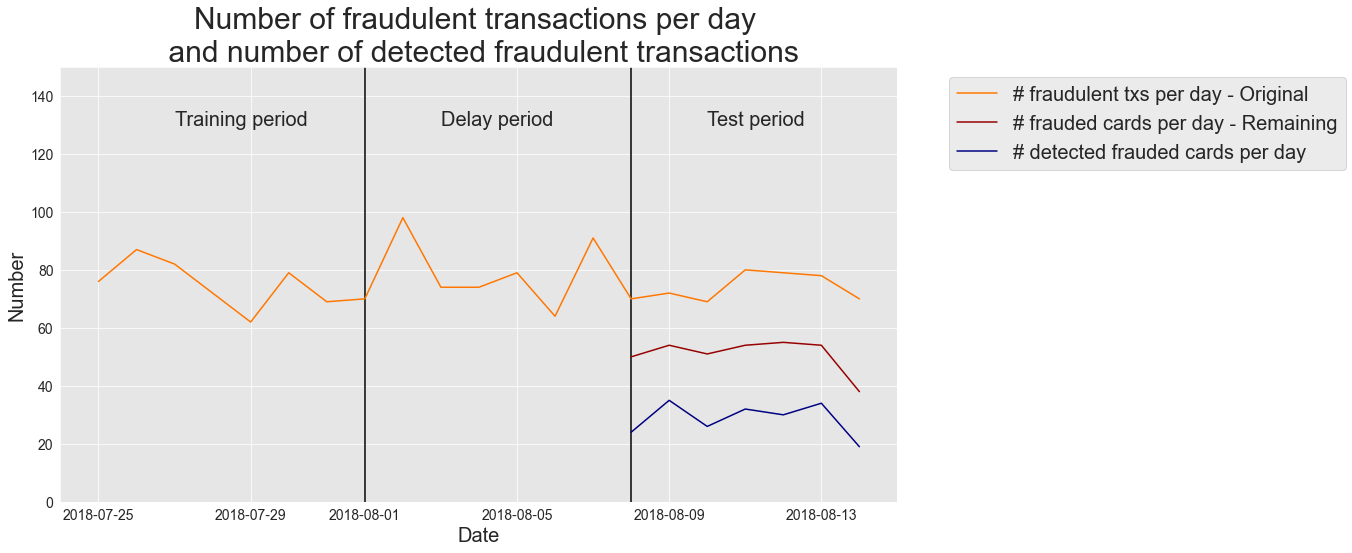

In [10]:
fraud_and_transactions_stats_fig

The results are qualitatively similar to those obtained using the Precision top-$k$. In the test period, the number of frauded cards varied between 69 and 80. Once transactions from known frauded cards were removed, the remaining frauded cards varied between 38 and 55. Out of these remaining frauded cards, the fraud detector correctly detected between 19 and 35 cards, with an average number of 29 frauded cards detected per day (average Card Precision Top-$k$=0.33), that is, about 60% of the actual frauded cards were detected.  

Finally, it should be noted that once a frauded card has been detected, it is blocked and therefore should be removed from the pool of transactions. Let us amend the `card_precision_top_k` to remove frauded cards that have been detected.

In [11]:
def card_precision_top_k(predictions_df, top_k, remove_detected_frauded_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    # At first, the list of detected frauded cards is empty
    list_detected_frauded_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_frauded_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Let us remove detected frauded cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_frauded_cards)==False]
        
        nb_frauded_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        detected_frauded_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Let us update the list of detected frauded cards
        if remove_detected_frauded_cards:
            list_detected_frauded_cards.extend(detected_frauded_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_frauded_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k


In [12]:
nb_frauded_cards_per_day_remaining\
,card_precision_top_k_per_day_list\
,mean_card_precision_top_k=card_precision_top_k(predictions_df=predictions_df, top_k=100)

print("Number of remaining frauded cards: "+str(nb_frauded_cards_per_day_remaining))
print("Precision top-k: "+str(card_precision_top_k_per_day_list))
print("Average Precision top-k: "+str(mean_card_precision_top_k))



Number of remaining frauded cards: [50, 50, 49, 47, 46, 44, 31]
Precision top-k: [0.24, 0.32, 0.27, 0.25, 0.23, 0.26, 0.12]
Average Precision top-k: 0.2414285714285714


We note that the number of remaining frauded cards is lower, since detected frauded cards are removed from the pool of transactions.

In [13]:
# Compute the number of transactions per day, 
#fraudulent transactions per day and fraudulent cards per day
tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")

# Add the remaining number of frauded cards for the last 7 days (test period)
tx_stats.loc[14:20,'nb_frauded_cards_per_day_remaining']=list(nb_frauded_cards_per_day_remaining)

# Add the card precision top k for the last 7 days (test period) 
tx_stats.loc[14:20,'card_precision_top_k_per_day']=card_precision_top_k_per_day_list


In [14]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

cmap = plt.get_cmap('jet')
colors={'card_precision_top_k_per_day':cmap(0), 
        'nb_frauded_cards_per_day':cmap(200),
        'nb_frauded_cards_per_day_remaining':cmap(250),
       }

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Number of fraudulent transactions per day \n and number of detected fraudulent transactions',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test,
                      ylim=150
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_frauded_cards_per_day'], 'b', color=colors['nb_frauded_cards_per_day'], label = '# frauded cards per day - Original')
ax.plot(tx_stats['tx_date'], tx_stats['nb_frauded_cards_per_day_remaining'], 'b', color=colors['nb_frauded_cards_per_day_remaining'], label = '# frauded cards per day - Remaining')
ax.plot(tx_stats['tx_date'], tx_stats['card_precision_top_k_per_day']*100, 'b', color=colors['card_precision_top_k_per_day'], label = '# detected frauded cards per day')

ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)

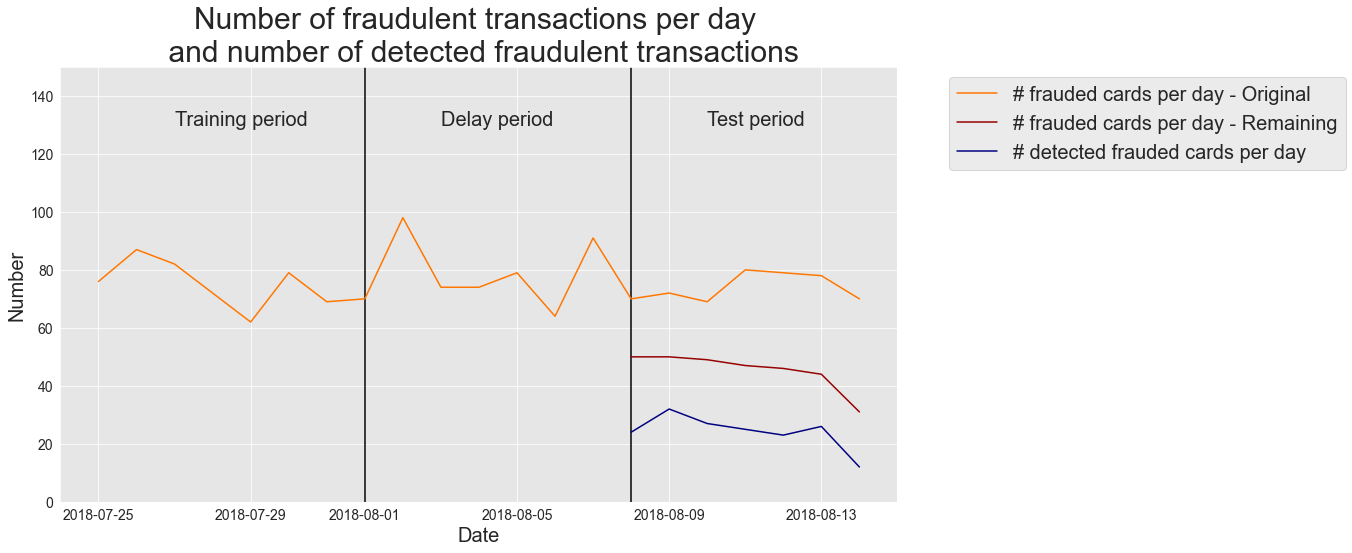

In [15]:
fraud_and_transactions_stats_fig

This last implementation of `card_precision_top_k` is the one included in the [shared functions](shared_functions) notebook and used in the next chapters. 